In [1]:
%load_ext autoreload
%autoreload 2

# Comparing model-generated ruggedness and sequence-level ruggedness

In [2]:
import os
import pandas as pd
import jax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoscaper.utils.evolution import calculate_ruggedness_core
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from bioreaction.misc.misc import load_json_as_dict


jax.config.update('jax_platform_name', 'cpu')

In [3]:
# Load dataset 1127
fn_1127 = os.path.join('..', 'data', 'raw', 'summarise_simulation', '2024_11_27_145142', 'tabulated_mutation_info.csv')
ds_1127 = pd.read_csv(fn_1127)
ds_1127.sort_values(by=['circuit_name', 'mutation_num', 'sample_name'], inplace=True)

# Load dataset 0211
# fn_0211 = os.path.join('data', 'simulate_circuits', '2025_02_11__13_56_51', 'tabulated_mutation_info.json')
# ds_0211 = pd.read_json(fn_0211)

# Load model for ruggedness


# Load previously verified ruggedness fake circuits


In [4]:
n_species = ds_1127['sample_name'].dropna().nunique()
if 'Log sensitivity' not in ds_1127.columns:
    ds_1127['Log sensitivity'] = np.log10(ds_1127['sensitivity'])
    ds_1127['Log precision'] = np.log10(ds_1127['precision'])
if 'adaptation' not in ds_1127.columns:
    ds_1127['adaptation'] = calculate_adaptation(ds_1127['sensitivity'].values, ds_1127['precision'].values, alpha=2)
    
filt_spec = ds_1127['sample_name'] != 'RNA_0'
filt_e = ds_1127['sample_name'] == 'RNA_2'

# Ruggedness of sequence

In [5]:
def calc_diffs(data, columns):
    diffs = data.groupby(['circuit_name', 'sample_name']).apply(
        lambda x: x[x['mutation_name'] == 'ref_circuit'][columns].values
        - x[x['mutation_name'] != 'ref_circuit'][columns].values)
    return np.array(diffs.to_list())


def calc_ratio(x, columns):
    values_mut = x[x['mutation_name'] != 'ref_circuit'][columns].values
    values_ref = x[x['mutation_name'] == 'ref_circuit'][columns].values
    ratios = np.where(values_ref == 0, 1 + (values_mut - values_ref),
                      values_mut / values_ref)
    return ratios


def calc_divs(data, columns):
    diffs = data.groupby(['circuit_name', 'sample_name']).apply(
        lambda x: calc_ratio(x, columns))
    return np.array(diffs.to_list())


def calc_ruggedness_seq(data, columns, mut_nums, n_species):
    """ rugg = Sig [ log10( mut / org ) / ( Sig nmut^2 ) ] 
    Going towards zero means robustness.
    Negative values indicate ruggedness in the function-deteriorating direction. """
    divs = calc_divs(data, columns).reshape(n_species, -1, mut_nums.shape[-1])
    divs_norm_log = np.log10(divs) / np.power(np.repeat(mut_nums,
                                                        repeats=n_species).reshape(divs.shape), 2)
    rugg = np.sum(divs_norm_log, axis=-1)
    return rugg

In [6]:
# Calculate approximate ruggedness score for all circuits based on difference to mutated circuits
# Weight the metric by the number of sequence mutations, eg: dm = d1m / 1 + d2m / 2 + d5m / 5

mut_nums = np.array(ds_1127[filt_e & (ds_1127['mutation_num'] > 0)].groupby(
    'circuit_name').apply(lambda x: x['mutation_num'].values).to_list())

cols_e = get_true_interaction_cols(
    ds_1127, 'energies', remove_symmetrical=True)
diffs_e = calc_diffs(ds_1127[filt_e], cols_e)
rugg_seq_e = np.sum(diffs_e / mut_nums[..., None], axis=-1)

# Plot seq-based rugg and param-based rugg on x y plot -> should be linear

# Plot intensity of energy changed vs. sequence change

# Run full model on ds 0211 + 1127 and compare latent spaces
# Do clusters of motifs

/tmp/ipykernel_1723812/3419390456.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'circuit_name').apply(lambda x: x['mutation_num'].values).to_list())
/tmp/ipykernel_1723812/1906409201.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diffs = data.groupby(['circuit_name', 'sample_name']).apply(


/tmp/ipykernel_1723812/1906409201.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diffs = data.groupby(['circuit_name', 'sample_name']).apply(
/tmp/ipykernel_1723812/1906409201.py:27: RuntimeWarning: invalid value encountered in log10
  divs_norm_log = np.log10(divs) / np.power(np.repeat(mut_nums,


Text(0.5, 0, 'Ruggedness (sequence)')

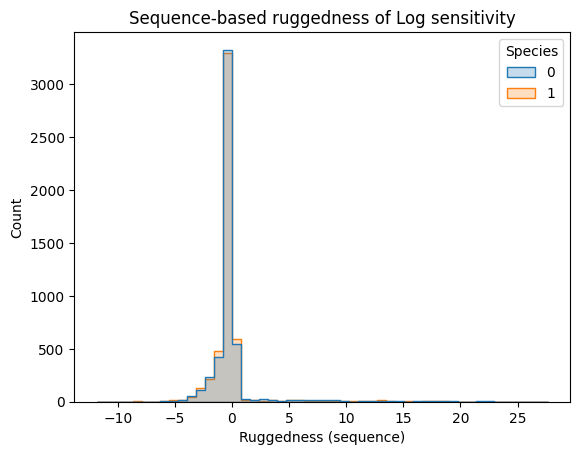

In [7]:
k = 'Log sensitivity'
rugg_seq_sens = calc_ruggedness_seq(ds_1127[filt_spec], k, mut_nums, n_species=n_species-1)

ax = sns.histplot(rugg_seq_sens.T.reshape(-1, n_species-1), bins=50, log_scale=[False, False], element='step')
# sns.histplot(x=np.log10(diffs_sens).flatten(), hue=np.repeat(mut_nums, repeats=3).flatten(), bins=50, log_scale=[False, False], element='step')
plt.title(f'Sequence-based ruggedness of {k}')
ax.get_legend().set_title('Species')
plt.xlabel('Ruggedness (sequence)')

/tmp/ipykernel_1723812/1906409201.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diffs = data.groupby(['circuit_name', 'sample_name']).apply(


Text(0.5, 0, 'Ruggedness (sequence)')

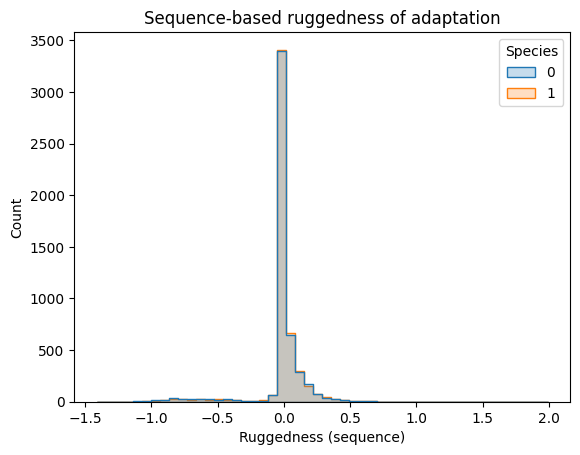

In [8]:
k = 'adaptation'
rugg_seq = calc_ruggedness_seq(ds_1127[filt_spec], k, mut_nums, n_species=n_species-1)

ax = sns.histplot(rugg_seq.T.reshape(-1, n_species-1), bins=50, log_scale=[False, False], element='step')
# sns.histplot(x=np.log10(diffs_sens).flatten(), hue=np.repeat(mut_nums, repeats=3).flatten(), bins=50, log_scale=[False, False], element='step')
plt.title(f'Sequence-based ruggedness of {k}')
ax.get_legend().set_title('Species')
plt.xlabel('Ruggedness (sequence)')

In [9]:
# ds_1127['Ruggedness (seq) energies'] = np.repeat(np.concatenate(
#     [rugg_seq_e, np.zeros(len(rugg_seq_e))[:, None]], axis=-1), repeats=3)
# ds_1127[f'Ruggedness (seq) {k}'] = np.concatenate(
#     [rugg_seq_sens, np.zeros(len(rugg_seq_sens))[:, None]], axis=-1)


# Ruggedness of topology

In [10]:
# Stitch together ruggedness from batches
# analytics_rugg = {}
# # for fn_analytic in ['analytics.json', 'analytics2.json']:
# for dir_batch in [f'batch_{i}' for i in np.arange(12)]:
#     if (not os.path.exists(os.path.join(dir_rugg_1127, dir_batch))) or (
#         len(os.listdir(os.path.join(dir_rugg_1127, dir_batch))) == 0):
#         continue
#     analytics_batch = load_json_as_dict(os.path.join(dir_rugg_1127, dir_batch, 'analytics.json'))
#     # analytics_batch = load_json_as_dict(os.path.join(dir_rugg_1127, fn_analytic))
#     for k, v in analytics_batch.items():
#         if k not in analytics_rugg:
#             analytics_rugg[k] = np.array(v)
#         else:
#             analytics_rugg[k] = np.concatenate([analytics_rugg[k], np.array(v)], axis=0)
            
# if 'adaptation' not in analytics_rugg.keys():
#     analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

# from synbio_morpher.utils.data.data_format_tools.common import write_json
# write_json(analytics_rugg, os.path.join(dir_rugg_1127, 'analytics.json'))

In [11]:
dir_rugg_1127 = '/workdir/notebooks/data/ruggedness/2025_03_17__17_28_22'

config_run = load_json_as_dict(os.path.join(dir_rugg_1127, 'config.json'))
k = 'adaptation'
resimulate_analytics = config_run['resimulate_analytics']
interactions = ds_1127[filt_e][cols_e].values
n_samples = len(interactions)
n_perturbs = len(cols_e) + int(resimulate_analytics)
eps = config_run['eps_perc'] * np.abs(interactions).max()

fn_rugg = os.path.join(dir_rugg_1127, f'ruggedness_{k}.npy')
fn_rugg_analytic = os.path.join(dir_rugg_1127, f'analytics_{k}.npy')

if os.path.exists(fn_rugg):
    ruggedness = np.load(fn_rugg)
if os.path.exists(fn_rugg_analytic):
    analytics_rugg_k = np.load(fn_rugg_analytic)
    analytics_rugg = {k: analytics_rugg_k}
    ruggedness = calculate_ruggedness_core(analytics_rugg, None, k,
                                           config_run, n_samples, n_perturbs, eps)
    del analytics_rugg
else:
    analytics_rugg = load_json_as_dict(
        os.path.join(dir_rugg_1127, 'analytics.json'))

    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(
            np.array(analytics_rugg['sensitivity']), np.array(analytics_rugg['precision']), alpha=2)

    ruggedness = calculate_ruggedness_core(analytics_rugg, None, k,
                                           config_run, n_samples, n_perturbs, eps)

    np.save(fn_rugg, ruggedness)
    np.save(fn_rugg_analytic, np.array(analytics_rugg[k]))
    del analytics_rugg

In [12]:
# ruggedness
filt_usedsim = ds_1127['sample_name'] == 'RNA_2'
ds_1127_usedsim = ds_1127[filt_usedsim]
ds_1127_usedsim = ds_1127_usedsim.reset_index()
idxs_linked = ds_1127_usedsim[ds_1127_usedsim['mutation_name'] == 'ref_circuit'].index.to_list()

idx_output = -1
rugg_seq[idx_output].shape

(5000,)

In [13]:
analytics_rugg_k = np.load(fn_rugg_analytic)
analytics_rugg = {k: analytics_rugg_k}
ruggedness_alt = calculate_ruggedness_core(analytics_rugg, None, k,
                                        config_run, n_samples, n_perturbs, eps, use_alt_algo=True)

ds_1127['Ruggedness (param)'] = np.nan
ds_1127.loc[filt_usedsim, 'Ruggedness (param)'] = ruggedness[..., idx_output]
ds_1127['Ruggedness alt (param)'] = np.nan
ds_1127.loc[filt_usedsim, 'Ruggedness (param)'] = ruggedness_alt[..., idx_output]
ds_1127['mutation_name_sub'] = ds_1127['mutation_name'].apply(
    lambda x: int(x.split('_')[-1].split('-')[-1]) if x != 'ref_circuit' else 0)
ds_1127['mutation_species'] = ds_1127['mutation_name'].apply(
    lambda x: '_'.join(x.split('_')[:2]) if x != 'ref_circuit' else np.nan)
ds_1127['Ruggedness (param) per circuit'] = ruggedness[idxs_linked, idx_output].repeat(
    repeats=ds_1127['circuit_name'].value_counts()[0])
ds_1127['Ruggedness alt (param) per circuit'] = ruggedness_alt[idxs_linked, idx_output].repeat(
    repeats=ds_1127['circuit_name'].value_counts()[0])
ds_1127['mutation_num'] = ds_1127['mutation_num'].astype(int)

/tmp/ipykernel_1723812/1163460102.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  repeats=ds_1127['circuit_name'].value_counts()[0])
/tmp/ipykernel_1723812/1163460102.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  repeats=ds_1127['circuit_name'].value_counts()[0])


<Axes: ylabel='Count'>

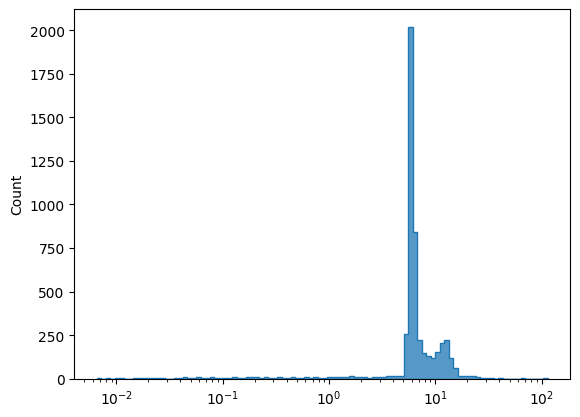

In [14]:
sns.histplot(ruggedness[idxs_linked, idx_output], bins=100, log_scale=[True, False], element='step')

In [15]:
cols_e_diffs = sorted([f'energies_diff_{c.split("_")[-1]}' for c in cols_e])

ds_1127[cols_e_diffs] = ds_1127.groupby(by='circuit_name')[
    cols_e].apply(lambda x: x.iloc[0] - x).reset_index(drop=True).sort_index().values
ds_1127['Log10 sensitivity'] = np.log10(ds_1127['sensitivity'])
ds_1127['Log10 sensitivity diff'] = ds_1127.groupby(by='circuit_name')[
    'Log10 sensitivity'].apply(lambda x: x.iloc[0] - x).reset_index(drop=True).sort_index().values
ds_1127['adaptation diff'] = ds_1127.groupby(by='circuit_name')[
    'adaptation'].apply(lambda x: x.iloc[0] - x).reset_index(drop=True).sort_index().values

<Axes: ylabel='Count'>

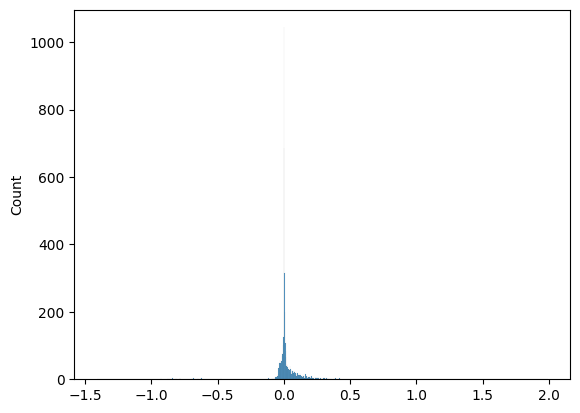

In [16]:
# sns.histplot(ds_1127[filt_e], x='adaptation diff', hue='mutation_num', bins=100, log_scale=[False, True], element='step')

sns.histplot(rugg_seq[idx_output])

# Rank circuits by ruggedness for seq and topology

Text(0.5, 1.0, 'Ruggedness of perturbed sequences and parameters')

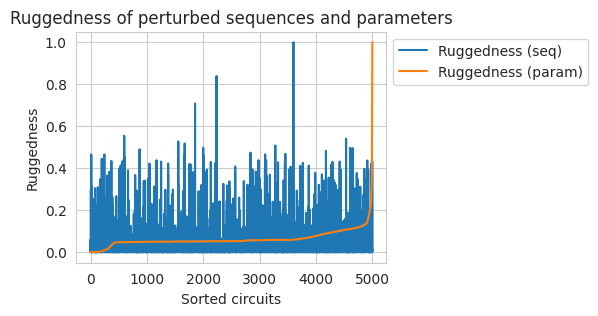

In [17]:
sns.set_style('whitegrid')
d_plot = pd.DataFrame()
d_plot['Circuit'] = ds_1127_usedsim.iloc[idxs_linked]['circuit_name'].values
d_plot['Circuit ID'] = d_plot['Circuit'].apply(lambda x: int(x.split('_')[-1]))
d_plot['Ruggedness (seq)'] = np.abs(rugg_seq[idx_output]) / np.nanmax(np.abs(rugg_seq[idx_output]))
d_plot['Ruggedness (param)'] = ruggedness[idxs_linked, idx_output] / np.nanmax(ruggedness[idxs_linked, idx_output])
d_plot['Sorted circuits'] = 0
d_plot.loc[d_plot.sort_values(by='Ruggedness (param)').index, 'Sorted circuits'] = np.arange(len(d_plot))
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.lineplot(d_plot, x='Sorted circuits', y='Ruggedness (seq)', label='Ruggedness (seq)', ax=ax)
sns.lineplot(d_plot, x='Sorted circuits', y='Ruggedness (param)', label='Ruggedness (param)', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel('Ruggedness')
ax.set_title('Ruggedness of perturbed sequences and parameters')

# Of the robust circuits (by seq), what proportion transitioned into a robust (by topology) space?

In [18]:
from evoscaper.utils.preprocess import make_datetime_str
top_write_dir = os.path.join('data', '15_ruggedness_cvae', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

In [19]:
ds_1127.sort_values(by=['circuit_name', 'mutation_num', 'mutation_name', 'sample_name'], inplace=True)
filt_e = ds_1127['sample_name'] == 'RNA_2'


In [20]:
ds_1127['mutation_name_sub'].max()

np.int64(7)

In [21]:
filt = filt_e & (ds_1127['Log sensitivity'] > 0) & (
    ds_1127['Log precision'] > 10)

n_species = 3
n_mutated_per_circuit = ds_1127['mutation_name_sub'].max()
idxs_sorted_mutated = ds_1127[filt_e & (ds_1127['mutation_num'] > 0)].sort_values(
    by=['circuit_name', 'mutation_species', 'mutation_name_sub', 'mutation_num', 'sample_name']).index
idxs_sorted_ref = ds_1127[filt_e & (ds_1127['mutation_num'] == 0)].sort_values(
    by=['circuit_name', 'mutation_species', 'mutation_name_sub', 'mutation_num', 'sample_name']).index
hue = 'Ruggedness alt (param) per circuit'

traj_mut = ds_1127.loc[idxs_sorted_mutated][[
    'mutation_num', 'Ruggedness (param)', hue]].values.T.reshape(3, -1, n_mutated_per_circuit)
traj_ref = ds_1127.loc[idxs_sorted_ref][['mutation_num',
                                          'Ruggedness (param)', hue]].values.T.reshape(3, -1, 1)
trajs = np.concatenate([traj_ref.repeat(repeats=(n_mutated_per_circuit + 1) * n_species, axis=1),
                        traj_mut], axis=-1)
trajs.shape

(3, 120000, 8)

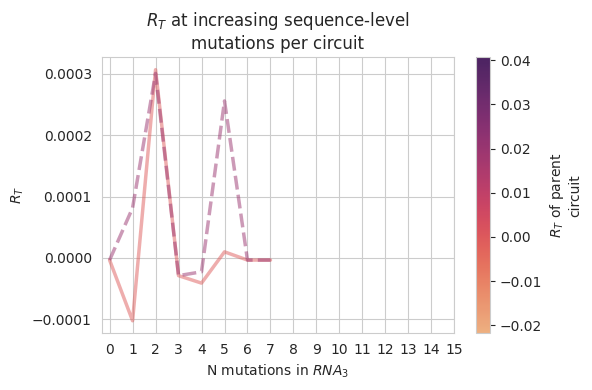

In [22]:
palette = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]
palette_cmap = sns.color_palette("blend:#4CC9F0,#3A0CA3,#F72585", as_cmap=True)
plt.figure(figsize=(6, 4))
# g = sns.lineplot(ds_1127[(ds_1127['mutation_name_sub'] == 0) & filt_e & (ds_1127['mutation_name'].str.contains('RNA_2') | (ds_1127['mutation_name'].str.contains('ref')))], #.iloc[:100],
# g = sns.lineplot(ds_1127[ds_1127['sample_name'] == 'RNA_2'], #.iloc[:100],
#                  x='mutation_num', y='Ruggedness (param)', hue='Ruggedness alt (param) per circuit', alpha=0.5, palette='flare', legend=False, linewidth=2.5, estimator=None)
g = sns.lineplot(trajs[1, :2].T, palette='flare', alpha=0.5, legend=False, linewidth=2.5, estimator=None)
norm = plt.Normalize(ds_1127['Ruggedness alt (param) per circuit'].min(), ds_1127['Ruggedness alt (param) per circuit'].max())
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sm.set_array([])
g.figure.colorbar(sm, ax=g, label=f'$R_T$ of parent\ncircuit')
# sns.move_legend(g, "upper left", bbox_to_anchor=(
#     1, 1), title=f'$R_T$ of parent\ncircuit')
plt.title(f'$R_T$ at increasing sequence-level\nmutations per circuit')
plt.xlabel('N mutations in $RNA_3$')
plt.ylabel(f'$R_T$')
plt.tight_layout()
plt.xticks(np.arange(0, ds_1127['mutation_num'].max() + 1, 1))
plt.savefig(os.path.join(top_write_dir, 'ruggedness_param.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Adaptable circuits that are robust both topologically and sequence-level

In [23]:
filt = (ds_1127['sample_name'] == 'RNA_2') & (ds_1127['Log sensitivity'] > 0) & (ds_1127['Log precision'] > 10)

sns.(ds_1127)

SyntaxError: invalid syntax (1174122364.py, line 3)